## Run subject routine

In [1]:
from utils.config import *
import pandas as pd
import numpy as np
from utils import dataset as ds
from utils import emg_handler
import efcp_routine
import os
import importlib
import matplotlib.pyplot as plt

subject = 100
efcp_routine.subject_routine(subject=subject, fs_force=500, fs_emg=2148.1481, bpf=[20, 500], lpf=20, debug=0)

Processing block 1


KeyboardInterrupt: 

## Making the models

In [23]:
D = pd.read_csv(os.path.join(ANALYSIS_PATH, f'efcp_100.csv'))
emg = pd.read_csv(os.path.join(ANALYSIS_PATH, f'efcp_100_emg.csv'))
mov = pd.read_csv(os.path.join(ANALYSIS_PATH, f'efcp_100_mov.csv'))

### Visual inspection of the data

/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_7282/1607632200.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emg_trial['e5'] = emg_trial['e5']*50


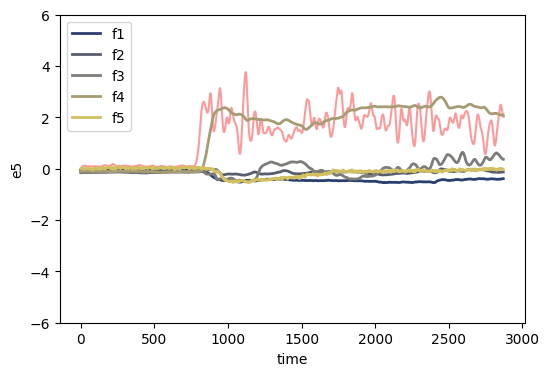

In [22]:
from utils.config import *
import pandas as pd
import numpy as np
from utils import dataset as ds
from utils import emg_handler
import efcp_routine
import os
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

BN = 1
TN = 9

mov_trial = mov[(mov['BN'])==BN & (mov['TN']==TN) & (mov['state']<4)]
emg_trial = emg[(emg['BN'])==BN & (emg['TN']==TN)]

# plot force:
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(6, 4))
colors = sns.color_palette("cividis", 5)  # Generate a list of 5 colors from the 'cividis' palette

# Plot emg:
emg_trial['e5'] = emg_trial['e5']*50
sns.lineplot(data=emg_trial, x='time', y='e5', ax=ax1, color='r', alpha=0.4)

# Plot force
sns.lineplot(data=mov_trial, x='time', y='f1', ax=ax1, label='f1', color=colors[0], lw=2)
sns.lineplot(data=mov_trial, x='time', y='f2', ax=ax1, label='f2', color=colors[1], lw=2)
sns.lineplot(data=mov_trial, x='time', y='f3', ax=ax1, label='f3', color=colors[2], lw=2)
sns.lineplot(data=mov_trial, x='time', y='f4', ax=ax1, label='f4', color=colors[3], lw=2)
sns.lineplot(data=mov_trial, x='time', y='f5', ax=ax1, label='f5', color=colors[4], lw=2)
ax1.set_ylim([-6, 6])
# ax1.set_ylabel('Force')
ax1.legend()

plt.show()

### Avg muscle activity patterns matrix

In [ ]:
# Chords ordered:
chords = np.array(['92999', '99299', '99929', '91999', '99199', '99919', 
                         '92299', '99229', '92929', '92199', '91299', '92919', '91929', '99219', '99129', '91199', '99119', '91919',
                         '92229', '92219', '91229', '92129', '92119', '91219', '91129', '91119'])
num_channels = 10
channels = ['f1', 'f2', 'f3', 'f4', 'f5', 'e1', 'e2', 'e3', 'e4', 'e5']

M = []
chordID = []
for chord in chords:
    # find the rows in D that correspond to the chord:
    rows = D[(D['chordID']==int(chord)) & (D['trial_correct']==1)]

    BN = rows['BN'].values.flatten()
    TN = rows['TN'].values.flatten()

    # loop on all trials:
    for i in range(len(BN)):
        # get the EMG data for the trial:
        emg_trials = emg[(emg['BN']==BN[i]) & (emg['TN']==TN[i])]
        emg_trials = emg_trials[emg_trials['state'] == 3.0]
        avg_emg_pattern = emg_trials[channels].mean().to_numpy()
        M.append(avg_emg_pattern)
        chordID.append(int(chord))
M = np.vstack(M)
chordID = np.array(chordID, dtype=int).reshape(-1, 1)

df_M = pd.DataFrame(np.hstack((chordID, M)), columns=['chordID']+channels)
df_M['chordID'] = df_M['chordID'].astype(int)
df_M.to_csv(os.path.join(ANALYSIS_PATH, 'efcp_100_avgEMG.csv'), index=False)


### Heatmap

[Text(0.5, 0, 'f1'),
 Text(1.5, 0, 'f2'),
 Text(2.5, 0, 'f3'),
 Text(3.5, 0, 'f4'),
 Text(4.5, 0, 'f5'),
 Text(5.5, 0, 'e1'),
 Text(6.5, 0, 'e2'),
 Text(7.5, 0, 'e3'),
 Text(8.5, 0, 'e4'),
 Text(9.5, 0, 'e5')]

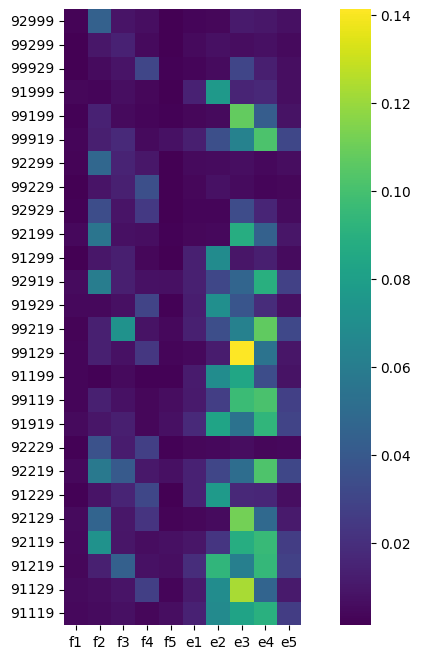

In [19]:
from utils.config import *
import pandas as pd
import numpy as np
from utils import dataset as ds
from utils import emg_handler
import efcp_routine
import os
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

df_M = pd.read_csv(os.path.join(ANALYSIS_PATH, 'efcp_100_avgEMG.csv'))

chords = np.array(['92999', '99299', '99929', '91999', '99199', '99919', 
                         '92299', '99229', '92929', '92199', '91299', '92919', '91929', '99219', '99129', '91199', '99119', '91919',
                         '92229', '92219', '91229', '92129', '92119', '91219', '91129', '91119'])
num_channels = 10
channels = ['f1', 'f2', 'f3', 'f4', 'f5', 'e1', 'e2', 'e3', 'e4', 'e5']

chordID = df_M['chordID'].values.flatten()
M = []
for chord in chords:
    # find and average the rows of the chord:
    trials = df_M[df_M['chordID'] == int(chord)]
    avg_emg_pattern = trials[channels].mean().to_numpy()
    M.append(avg_emg_pattern)
M = np.vstack(M)
norm_channels = np.linalg.norm(M, axis=0)
# M = M / norm_channels

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(M, cmap='viridis', ax=ax, square=True)
ax.set_yticks(np.arange(len(chords))+0.5)
ax.set_yticklabels(chords, rotation=0)
ax.set_xticks(np.arange(num_channels)+0.5)
ax.set_xticklabels(channels)
